## Model Selection

This notebook should include preliminary and baseline modeling.
- Try as many different models as possible.
- Don't worry about hyperparameter tuning or cross validation here.
- Ideas include:
    - linear regression
    - support vector machines
    - random forest
    - xgboost

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import LabelEncoder

# Load preprocessed data
file_path = os.path.join('..', 'data', 'processed', 'preprocessed_data.csv')
data = pd.read_csv(file_path)

# Define target and features
target_column = 'list_price'  # or another target column if different
y = data[target_column]
X = data.drop(columns=[target_column])

# Ensure that the 'city', 'state', and 'type' columns are excluded from the features
X = X.drop(columns=['city', 'state', 'type', 'sold_date', 'tags', 'filtered_tags'])

# 'list_price' converted to categorical labels: low, medium, high
bins = [0, 100000, 500000, float('inf')]  # Example bins
labels = ['Low', 'Medium', 'High']
y = pd.cut(y, bins=bins, labels=labels)

# Convert categorical labels to integer labels 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
feature_columns = X.columns 

X_train_df = pd.DataFrame(X_train, columns=feature_columns)
X_test_df = pd.DataFrame(X_test, columns=feature_columns)
y_train_series = pd.Series(y_train, name='target')  
y_test_series = pd.Series(y_test, name='target')

# save as csv
X_train_df.to_csv('../data/processed/X_train.csv', index=False)
X_test_df.to_csv('../data/processed/X_test.csv', index=False)
y_train_series.to_csv('../data/processed/y_train.csv', index=False)
y_test_series.to_csv('../data/processed/y_test.csv', index=False)

Consider what metrics you want to use to evaluate success.
- If you think about mean squared error, can we actually relate to the amount of error?
- Try root mean squared error so that error is closer to the original units (dollars)
- What does RMSE do to outliers?
- Is mean absolute error a good metric for this problem?
- What about R^2? Adjusted R^2?
- Briefly describe your reasons for picking the metrics you use

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# Impute missing values in features (X)
X_imputer = SimpleImputer(strategy='mean')  # or strategy='median'
X_train_imputed = X_imputer.fit_transform(X_train)
X_test_imputed = X_imputer.transform(X_test)

# Ensure no missing values in the target (y)
y_imputer = SimpleImputer(strategy='most_frequent') 
y_train_imputed = y_imputer.fit_transform(y_train.reshape(-1, 1)).ravel() 
y_test_imputed = y_imputer.transform(y_test.reshape(-1, 1)).ravel()

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Random Forest': RandomForestRegressor(),
    #'XGBoost': xgb.XGBRegressor()
}


results = {}

for model_name, model in models.items():
    model.fit(X_train_imputed, y_train_imputed)
    y_pred = model.predict(X_test_imputed)
    mae = mean_absolute_error(y_test_imputed, y_pred)  # You can also use other metrics like RMSE or R2
    results[model_name] = mae

# Display results
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Absolute Error'])
print(results_df)

                    Model  Mean Absolute Error
0       Linear Regression             0.682592
1  Support Vector Machine             0.338070
2           Random Forest             0.050528


Model accuracy score: 0.9837
sold_price: 0.2350
lot_sqft: 0.1235
price_per_sqft: 0.1220
sold_year: 0.0753
sqft: 0.0741
baths: 0.0712
baths_full: 0.0597
beds: 0.0546
garage: 0.0517
age_of_house: 0.0422
year_built: 0.0326
lot_sqft_scaled: 0.0146
stories: 0.0127
sqft_scaled: 0.0090
age_of_house_scaled: 0.0040
sold_price_scaled: 0.0031
list_price_scaled: 0.0029
price_per_sqft_scaled: 0.0026
beds_scaled: 0.0026
year_built_scaled: 0.0024
baths_scaled: 0.0023
baths_full_scaled: 0.0012
stories_scaled: 0.0010


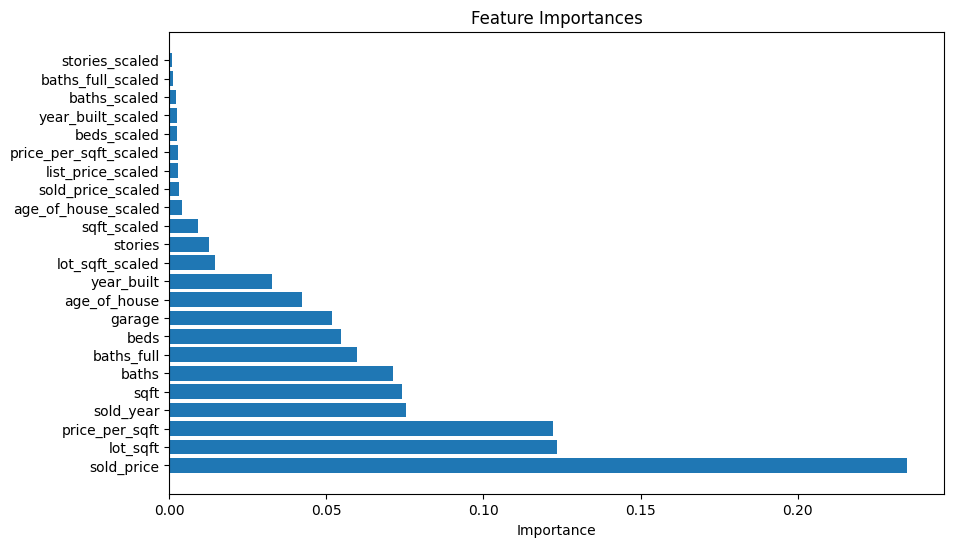

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
 
rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train_imputed, y_train_imputed)

y_pred = rfc.predict(X_test_imputed)

accuracy = accuracy_score(y_test_imputed, y_pred)
print(f'Model accuracy score: {accuracy:0.4f}')

importances = rfc.feature_importances_
feature_names = X.columns  

indices = np.argsort(importances)[::-1]  

for f in range(X_train_imputed.shape[1]):
    print(f"{feature_names[indices[f]]}: {importances[indices[f]] :.4f}")

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X_train_imputed.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train_imputed.shape[1]), feature_names[indices])
plt.xlabel("Importance")
plt.show()


Conclusion: High Importance Features that determine the house price are lot_sqft (0.1235), price_per_sqft (0.1220), sold_year (0.0753), sqft (0.0741), baths: (0.0712) 
Scaled features such as lot_sqft_scaled, sqft_scaled, baths_scaled, and stories_scaled have very low importance, indicating that these features do not contribute much to the model's decision-making process.

## Feature Selection - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its recommended you complete it if you have time!**

Even with all the preprocessing we did in Notebook 1, you probably still have a lot of features. Are they all important for prediction?

Investigate some feature selection algorithms (Lasso, RFE, Forward/Backward Selection)
- Perform feature selection to get a reduced subset of your original features
- Refit your models with this reduced dimensionality - how does performance change on your chosen metrics?
- Based on this, should you include feature selection in your final pipeline? Explain

Remember, feature selection often doesn't directly improve performance, but if performance remains the same, a simpler model is often preferrable. 



In [5]:
# perform feature selection 
# refit models
# gather evaluation metrics and compare to the previous step (full feature set)